<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**


---

# Wine demand prediction

Wine is, without a doubt, one of the most popular alcoholic beverages in the world. Although scientists are still unsure about the benefits of wine, the idea that having "one glass of wine a day" can help prevent heart attacks is somewhat widespread in society<sup><a href="https://www.mayoclinic.org/diseases-conditions/heart-disease/in-depth/red-wine/art-20048281">1</a></sup>. Moreover, the wine industry was one of the many things the COVID-19 pandemic had an impact on, with wine sales (especially online) spiking over 500% at the peak period of lockdown in April 2020<sup><a href="https://www.forbes.com/sites/joemicallef/2021/06/22/how-post-pandemic-wine-consumption-trends-are-shaping--demand/">2</a></sup>. Without such an atypical reason for this rise in sales, specialized wine stores might be able to predict their sales demand given that they have enough data on their sales over time.

<p align=center>
<img src="img/wine.jpg" width="40%"><br>
<i><sup>Image credits: wavebreakmedia-micro @ <a href="https://www.freepik.com/free-photo/glass-red-wine-bottle-bar-counter_8405671.htm">freepik</a>.</sup></i>
</p>

Such a representation of data is called a Time Series, and reflects a specific sequence of values measured along successive evenly spaced time points<sup><a href="https://en.wikipedia.org/wiki/Time_series">3</a></sup>. Predictions on Time Series — called **Time Series Forecasting** — is a form of *extrapolating* values in the future by leveraging previous data of interest and requires a specific methodology.

In this notebook, we will be predicting wine sales demand using [Facebook's Prophet](https://facebook.github.io/prophet/). Similar to PyCaret, Prophet is a low-code library that provides a strategy for working with time series forecasting based on an additive model that even takes into consideration holiday effects. It is also robust to missing data points and trend shifts, as well as able to handle outliers<sup><a href="https://facebook.github.io/prophet/">4</a></sup>.


## Demand forecasting and why it is important

**Demand forecasting** is, essentially, predicting the demand for products/materials that meet the company's needs, allowing for the maintenance of an optimal profit margin. It is constructed upon studying patterns in market dynamics, cause-effect relationships and trends of sales. And because changes constantly affect businesses, demand prediction becomes important from them<sup><a href="https://startup.info/why-demand-forecasting-is-important/">5</a></sup>.

Several factors can determine demand<sup><a href="https://byjus.com/commerce/demand/">6</sup></a>, such as the product costs, the consumers' incomes, the cost of related goods and services, consumer expectations well as the number of buyers in the market. All of these can be taken into account when trying to understand a particular product's demand.

On the other hand, **demand planning** is the process in which the business prepares itself for the *foreseeable* future, based on the forecast being made. With this, companies are able to stimulate consumer demand while also allowing the company to effectively meet the growing demand<sup><a href="https://startup.info/why-demand-forecasting-is-important/">5</a></sup>.

There are several benefits to be gained from time-series forecasting:

* **Price setting:** Predicting product popularity (or a lack thereof) allows for price adjustment (and setting up sales) which can have a great impact on revenue.
* **Budget:** Forecasting demand allows you to estimate the company budget, enabling you to reduce risk and make financial decisions, such as reallocating resources.
* **Improved supply infrastructure**: Knowing the business' demands allows for better control of inventory, of personnel needed.
* **Reducing uncertainty**: Uncertainty makes decision-making much more difficult, and knowing what to expect can reduce this impact and allow better planning.

Now that we have discussed this, let's dive in.

# The Data

The dataset used in the project today was a synthetic dataset created by Rafael at [Sigmoidal](https://sigmoidal.ai). It consists of a dataset from Kaggle which was modified to have 3 years of daily sales, distributed by 3 stores and 219 different products (modified from 5 years of daily sales, from 10 stores and 50 products). 

The products, though, are real and based on a real e-commerce offer of wines. Names, crops and prices are 100% real (in BRL and converted to USD). Some of the products might have appeared in the real market after a given start in sales for that product (for example, a wine from a 2015 crop started being sold in 2013, which makes no sense), but this is just the artifact of this artificial dataset. This might also be reflected in other unexpected characteristics like the trend in sales for a wine that is not very popular, for example.

From the products sheet, we will have the following variables:

* **item_id** = Item identification number.
* **name** = Name of the Wine.
* **producer** = Name of the Wine producer.
* **country** = Country of origin.
* **vintage** = The wine's vintage/harvest.
* **kind** = The type of wine.
* **price_brl** = Price in Brazilian Reais.
* **price_usd** = Price in US dollars.

While from the sales data we will have:

* **date** = The date of sale.
* **store** = The store that sold the item.
* **item** = The item that was sold.
* **sales** = The number of said items that were sold.

So, let's import our packages and prepare our data.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar
from pywaffle import Waffle
from prophet import Prophet
import tools as mytools
from statsmodels.tsa.stattools import adfuller


# Getting the data
df_prod = pd.read_csv("data/products.csv")
df_sale = pd.read_csv("data/sales-clean.csv")

# The Moon also rises
np.random.seed(6327)

# Defining plot parameters
# plt.style.use('dark_background')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.stretch'] = 'normal'
plt.rcParams['font.style'] = 'normal'
plt.rcParams['font.variant'] = 'normal'
plt.style.use('seaborn-muted')


## Data Preparation

### First look at the dataset

Let's take a first look at our data by observing our dataframes:

In [2]:
# Seeing first entries of products dataset
df_prod.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,NV,sparkling,339.60,58.75
1,2,Philipponnat Royale Reserve Rosé,Philipponat,France,Champagne,NV,rose sparkling,489.00,84.60
2,3,Philipponnat Cuvée 1522 Grand Cru Extra Brut,Philipponat,France,Champagne,2009,sparkling,789.00,136.51
3,4,Philipponnat Cuvée 1522 1er Cru Rosé,Philipponat,France,Champagne,2008,rose sparkling,899.40,155.61
4,5,Philipponnat Clos Des Goisses Brut,Philipponat,France,Champagne,2009,sparkling,"1,548.00",267.82


In [3]:
# Seeing first entries of sales dataset
df_sale.head()

,date,store,item,sales
0,2018-01-01,1,1,13
1,2018-01-02,1,1,11
2,2018-01-03,1,1,14
3,2018-01-04,1,1,13
4,2018-01-05,1,1,10


One of the first things that we see is that the prices have commas (,) in the numbers, which should not be present in numerical data. Let's go ahead and check all our data variables.

In [4]:
# Checking columns from data
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   item_id    219 non-null    int64 
 1   name       219 non-null    object
 2   producer   219 non-null    object
 3   country    219 non-null    object
 4   region     219 non-null    object
 5   vintage    219 non-null    object
 6   kind       219 non-null    object
 7   price_brl  219 non-null    object
 8   price_usd  219 non-null    object
dtypes: int64(1), object(8)
memory usage: 15.5+ KB


Both price columns seem to have text instead of numbers, while the IDs of the items are set as numbers, so we go ahead and fix that. The vintage column also contains text ("NV" entry) which we will change to 0 to keep the column numeric.

In [5]:
# Fixing numbers (removing ,)
df_prod.replace(',', '', regex=True, inplace=True)

# Fixing types
df_prod.item_id = df_prod.item_id.astype(str)
df_prod.price_brl = pd.to_numeric(df_prod.price_brl)
df_prod.price_usd = pd.to_numeric(df_prod.price_usd)



In [6]:
# Fixing vintage column
df_prod.vintage.replace('NV', '0', inplace=True)
df_prod.vintage = pd.to_numeric(df_prod.vintage)

In [7]:
# Checking
df_prod.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75
1,2,Philipponnat Royale Reserve Rosé,Philipponat,France,Champagne,0,rose sparkling,489.0,84.60
2,3,Philipponnat Cuvée 1522 Grand Cru Extra Brut,Philipponat,France,Champagne,2009,sparkling,789.0,136.51
3,4,Philipponnat Cuvée 1522 1er Cru Rosé,Philipponat,France,Champagne,2008,rose sparkling,899.4,155.61
4,5,Philipponnat Clos Des Goisses Brut,Philipponat,France,Champagne,2009,sparkling,1548.0,267.82


In [8]:
# Checking types
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   item_id    219 non-null    object 
 1   name       219 non-null    object 
 2   producer   219 non-null    object 
 3   country    219 non-null    object 
 4   region     219 non-null    object 
 5   vintage    219 non-null    int64  
 6   kind       219 non-null    object 
 7   price_brl  219 non-null    float64
 8   price_usd  219 non-null    float64
dtypes: float64(2), int64(1), object(6)
memory usage: 15.5+ KB


### Getting to know our dataset

But what about the products we are studying? Let's see what are the main features of our data.

In [9]:
# Printing info
print('Number of types of wine: ', len(df_prod.name.unique()))
print('Number of different producers: ', len(df_prod.producer.unique()))
print('Number of different countries: ', len(df_prod.country.unique()))
print('Number of different regions: ', len(df_prod.region.unique()))
print('Number of different types: ', len(df_prod.kind.unique()))
print('Number of vintages:', len(df_prod.vintage.unique()))
print('Price range (BRL):', min(df_prod.price_brl), '—', max(df_prod.price_brl))
print('Price range (USD):', min(df_prod.price_usd), '—', max(df_prod.price_usd))


Number of types of wine:  188
Number of different producers:  58
Number of different countries:  6
Number of different regions:  21
Number of different types:  5
Number of vintages: 17
Price range (BRL): 52.8 — 10992.0
Price range (USD): 9.13 — 1901.73


Even though this dataset was adapted to a smaller size, we can still see that we have a good range of products spanning a good price range as well. Diversity of price and options are essential for maintaining the sales and reaching every niche of wine enthusiasts. We can see that our dataset spans a wide range of producers, countries, regions and vintages, showing that the catalog can appeal to many audiences.


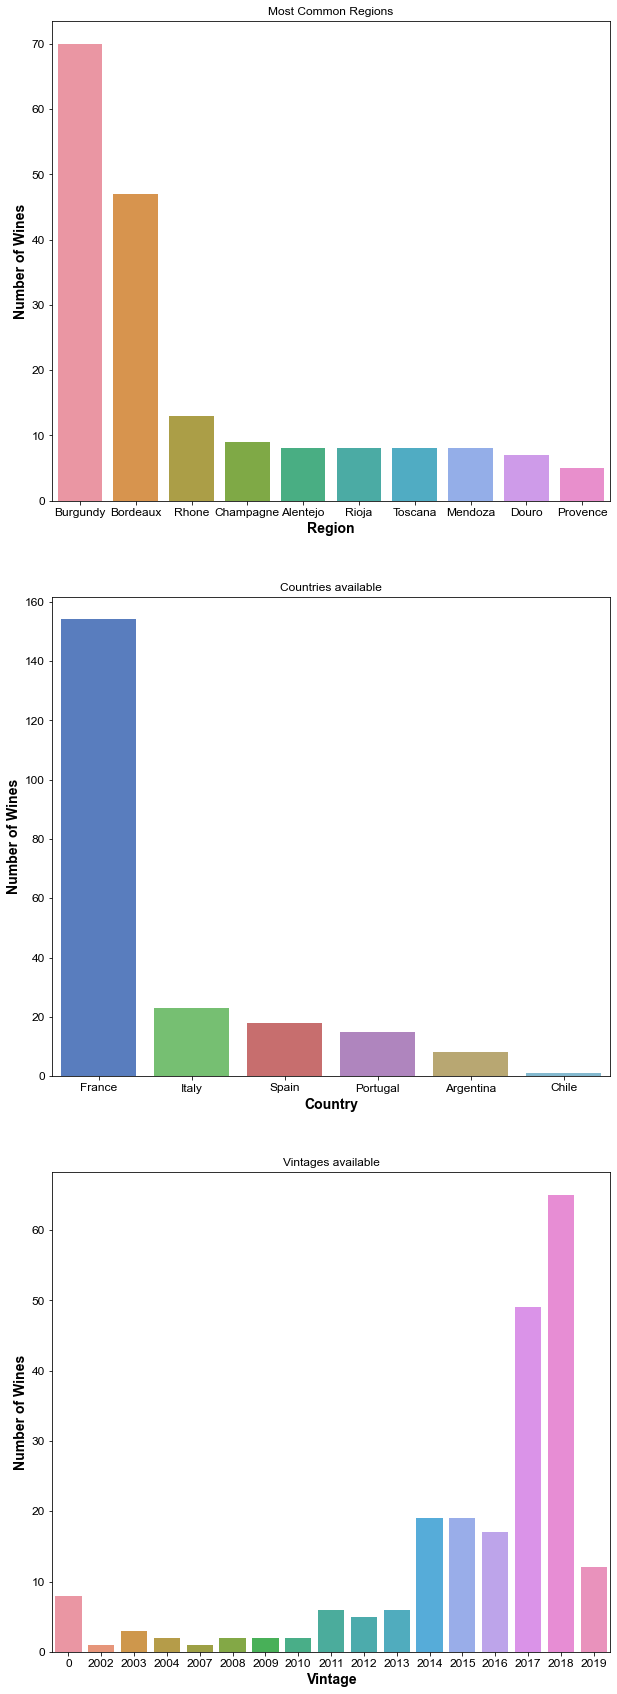

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(10,30))

# Regions
sns.countplot(x=df_prod.region, order=df_prod.region.value_counts().index[0:10], ax=ax[0]).set(title='Most Common Regions')
ax[0].tick_params(axis='both', labelsize=12)
ax[0].set_ylabel('Number of Wines', fontsize=14, weight='bold')
ax[0].set_xlabel('Region', fontsize=14, weight='bold')

# Countries
sns.countplot(x=df_prod.country, order=df_prod.country.value_counts().index, ax=ax[1]).set(title='Countries available')
ax[1].tick_params(axis='both', labelsize=12)
ax[1].set_ylabel('Number of Wines', fontsize=14, weight='bold')
ax[1].set_xlabel('Country', fontsize=14, weight='bold')

# Vintages
sns.countplot(x=df_prod.vintage, ax=ax[2]).set(title='Vintages available')
ax[2].tick_params(axis='both', labelsize=12)
ax[2].set_ylabel('Number of Wines', fontsize=14, weight='bold')
ax[2].set_xlabel('Vintage', fontsize=14, weight='bold')


plt.show()

As one would imagine, we have variation in the price due to region of origin as well as the vintage of the wine:

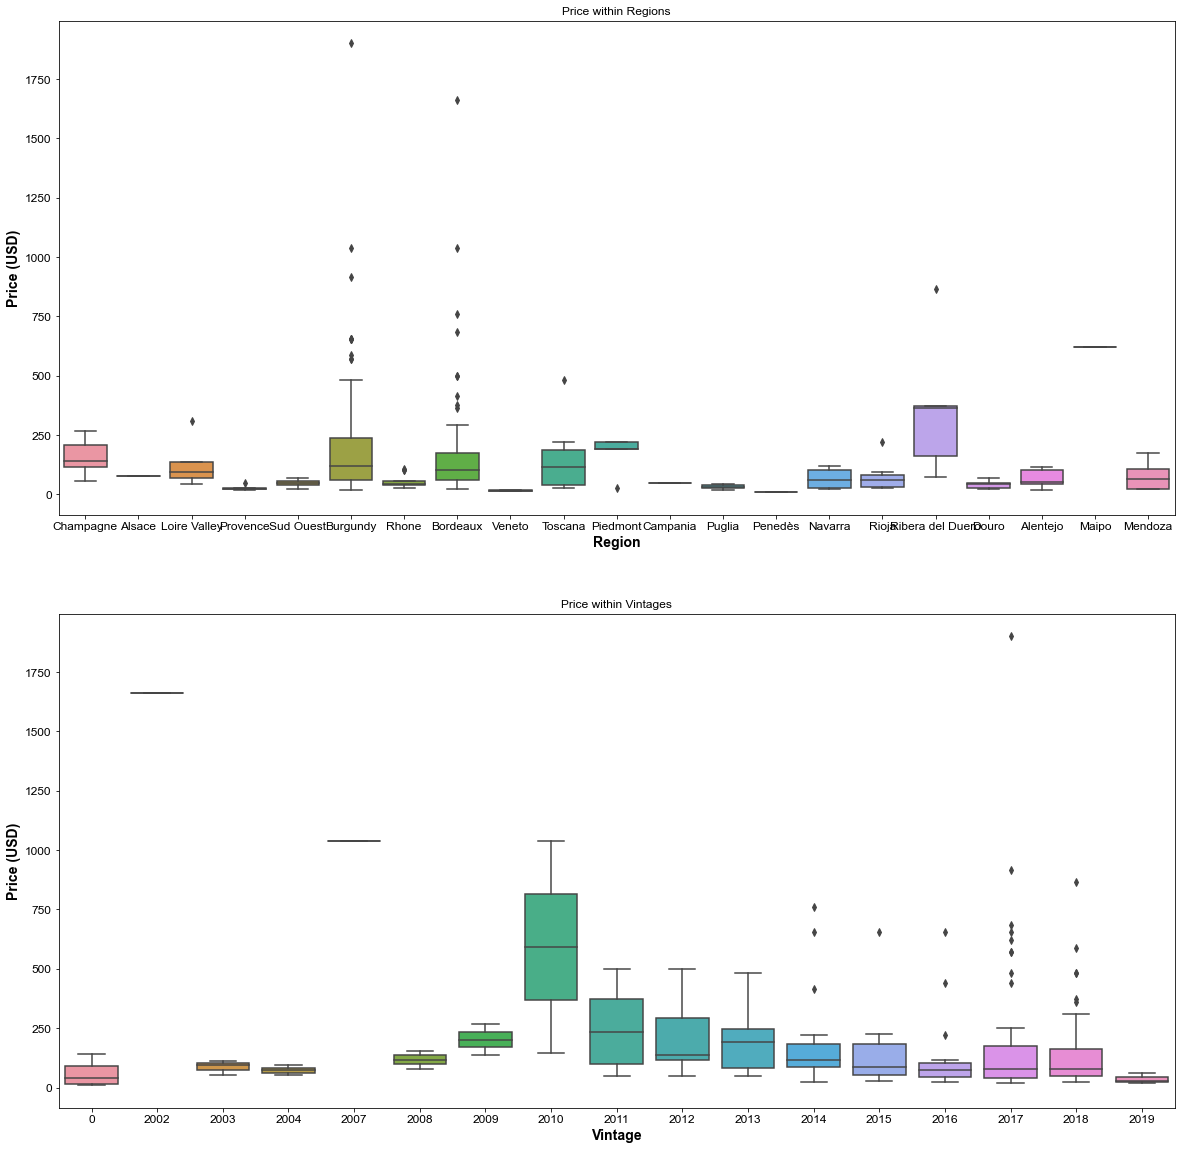

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(20,20))

# Regions
sns.boxplot(x=df_prod.region, y=df_prod.price_usd, ax=ax[0]).set(title='Price within Regions')
ax[0].tick_params(axis='both', labelsize=12)
ax[0].set_ylabel('Price (USD)', fontsize=14, weight='bold')
ax[0].set_xlabel('Region', fontsize=14, weight='bold')

# Countries
sns.boxplot(x=df_prod.vintage, y=df_prod.price_usd).set(title='Price within Vintages')
ax[1].tick_params(axis='both', labelsize=12)
ax[1].set_ylabel('Price (USD)', fontsize=14, weight='bold')
ax[1].set_xlabel('Vintage', fontsize=14, weight='bold')

plt.show()

From this, we can see that *Ribera del Duero* has a higher median price of wines, but both *Burdungy* and *Bordeaux* have the highest and second highest prices in our catalog. In addition, *2010 Vintages* have the highest median price, with the actual highest price being a *2017 Vintage*.

Let's see which are the most expensive and the cheapest wines available in our data.

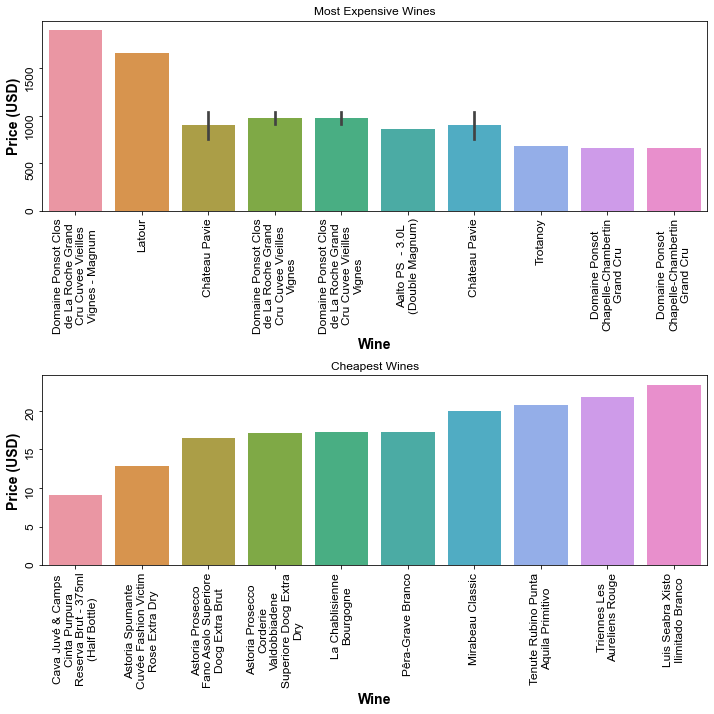

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))

# Most expensive wines
sns.barplot(x=df_prod.name, y=df_prod.price_usd, 
            order=df_prod.sort_values('price_usd', ascending=False).name.iloc[0:10], 
            ax=ax[0]).set(title='Most Expensive Wines')
mytools.wrap_labels(ax[0], 20)
ax[0].tick_params(rotation=90)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].set_ylabel('Price (USD)', fontsize=14, weight='bold')
ax[0].set_xlabel('Wine', fontsize=14, weight='bold')

# Cheapest wines
sns.barplot(x=df_prod.name, y=df_prod.price_usd, 
            order=df_prod.sort_values('price_usd', ascending=True).name.iloc[0:10], 
            ax=ax[1]).set(title='Cheapest Wines')
mytools.wrap_labels(ax[1], 20)
ax[1].tick_params(rotation=90)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].set_ylabel('Price (USD)', fontsize=14, weight='bold')
ax[1].set_xlabel('Wine', fontsize=14, weight='bold')

fig.tight_layout(pad=1)
plt.show()

In [13]:
# Cheapest and Most expensive wines
print('The cheapest wine in the catalog is:\n',
      df_prod.sort_values('price_usd', ascending=True).name.iloc[0],
      '\n Price: $' ,
      df_prod.sort_values('price_usd', ascending=True).price_usd.iloc[0],
      '\n')

print('The most expensive wine in the catalog is:\n',
      df_prod.sort_values('price_usd', ascending=False).name.iloc[0], 
      '\n Price: $' ,
      df_prod.sort_values('price_usd', ascending=False).price_usd.iloc[0], 
      '\n')

print('The mean price of wine in the store is:\n $',
      round(df_prod.price_usd.mean(), 2))

The cheapest wine in the catalog is:
 Cava Juvé & Camps Cinta Purpura Reserva Brut - 375ml (Half Bottle) 
 Price: $ 9.13 

The most expensive wine in the catalog is:
 Domaine Ponsot Clos de La Roche Grand Cru Cuvee Vieilles Vignes - Magnum 
 Price: $ 1901.73 

The mean price of wine in the store is:
 $ 167.41


Another important question to ask is how is the price range distribution in our dataset. Does the catalog focus on higher-priced wines or more accessible options?

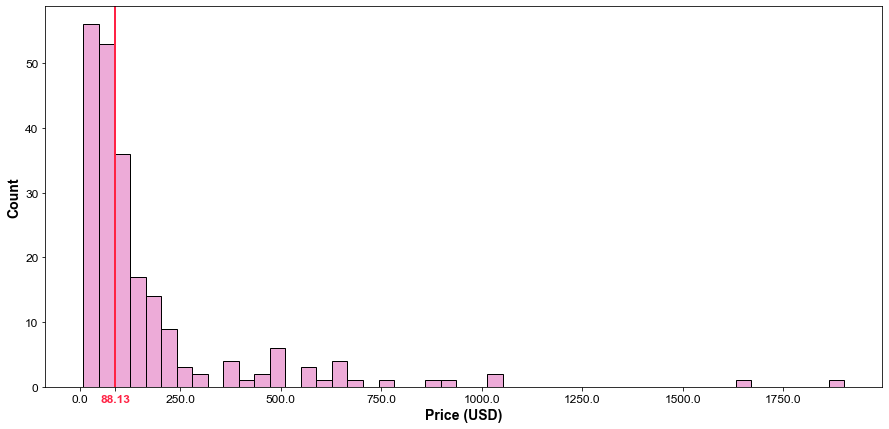

In [14]:
# Creating a price histogram
fig, ax = plt.subplots(figsize=(15,7))

sns.histplot(df_prod.price_usd, color='#e88fcc')
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel('Price (USD)', fontsize=14, weight='bold')
ax.set_ylabel('Count', fontsize=14, weight='bold')
plt.axvline(df_prod.price_usd.median(), color='#ff2345', linewidth=2)
lim = ax.get_xlim()
plt.xticks(list(plt.xticks()[0]) + [df_prod.price_usd.median()],list(plt.xticks()[0]) + [df_prod.price_usd.median()])
plt.setp(ax.get_xticklabels()[-1], color='#ff2345', weight='bold')
ax.set_xlim(lim)

plt.show()

Most of our wine range is below USD 250, with very few wines at elevated prices. To get more comprehensive insights, we'll now join the two datasets to match sales information with product details.

In [15]:
# First rename de columns
df_sale.rename(columns={'item': 'item_id'}, inplace=True)
df_sale.item_id = df_sale.item_id.astype(str)
df_sale.head()

,date,store,item_id,sales
0,2018-01-01,1,1,13
1,2018-01-02,1,1,11
2,2018-01-03,1,1,14
3,2018-01-04,1,1,13
4,2018-01-05,1,1,10


In [16]:
# Fixing df_prod item_id column
df_prod.item_id = df_prod.item_id.astype(str)

# Fixing date-times
df_sale.date = pd.to_datetime(df_sale.date)
df_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720071 entries, 0 to 720070
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   date     720071 non-null  datetime64[ns]
 1   store    720071 non-null  int64         
 2   item_id  720071 non-null  object        
 3   sales    720071 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 22.0+ MB


In [17]:
# Joining the two datasets
df_join = df_prod.merge(df_sale, on='item_id', how='right')

# Setting date as index
df_join.index = df_join.date
df_join.drop('date', axis=1, inplace=True)
df_join.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales
date,,,,,,,,,,,
2018-01-01,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13
2018-01-02,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,11
2018-01-03,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,14
2018-01-04,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13
2018-01-05,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,10


In [18]:
# Copying data.frame
df = df_join.copy()

# Extracting information from dates
df['dateofsale'] = df.index
df['dayofyear'] = df.index.dayofyear
df['day'] = df.index.day
df['week'] = df.index.isocalendar().week
df['weekday'] = df.index.weekday

# Coding weekends
df['weekend'] = [1 if x >= 5 else 0 for x in df.weekday]

# Rest of the variables
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year

In [19]:
# Checking weekends work
df.head(7)

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales,dateofsale,dayofyear,day,week,weekday,weekend,month,quarter,year
date,,,,,,,,,,,,,,,,,,,,
2018-01-01,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13,2018-01-01,1,1,1,0,0,1,1,2018
2018-01-02,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,11,2018-01-02,2,2,1,1,0,1,1,2018
2018-01-03,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,14,2018-01-03,3,3,1,2,0,1,1,2018
2018-01-04,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13,2018-01-04,4,4,1,3,0,1,1,2018
2018-01-05,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,10,2018-01-05,5,5,1,4,0,1,1,2018
2018-01-06,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,12,2018-01-06,6,6,1,5,1,1,1,2018
2018-01-07,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,10,2018-01-07,7,7,1,6,1,1,1,2018


In order to clean our dataset of possibly unnecessary values, let's check how our sales data were constructed over the years.

In [20]:
df.year

date
2018-01-01    2018
2018-01-02    2018
2018-01-03    2018
2018-01-04    2018
2018-01-05    2018
              ... 
2020-12-27    2020
2020-12-28    2020
2020-12-29    2020
2020-12-30    2020
2020-12-31    2020
Name: year, Length: 720071, dtype: int64

2020    240312
2018    239805
2019    239805
2016       149
Name: year, dtype: int64


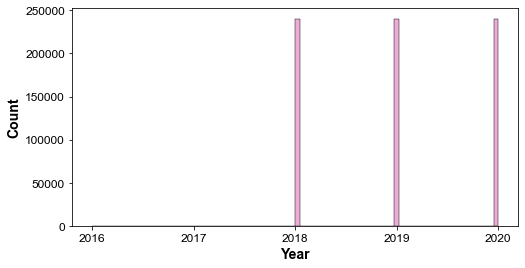

In [21]:
# Creating a price histogram
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(df.year, color='#e88fcc')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel('Year', fontsize=14, weight='bold')
ax.set_ylabel('Count', fontsize=14, weight='bold')

print(df.year.value_counts())

We will follow with the removal of 2016 values as they represent very little of our dataset.

In [22]:
# Removing values from 2016
df.drop(df[df.year==2016].index, axis=0, inplace=True)

Additionally, it would be interesting to understand which day of the week, which month of the year, which wine and which stores represented the biggest sales. Also, which wine represented more in terms of monetary gain? A cheap, mid-price or expensive wine? For that, we will have to summarise our dataset. Just plotting the number of entry counts would be an inaccurate measure, as many data points correspond to sales of more than one of the same item.

In [23]:
# First, create the real amount of money spent
df['purchase_total'] = df.price_usd * df.sales

# Summarising by time/sales
sum_day = df.groupby('weekday')['sales'].sum().to_frame()
sum_weekend = df.groupby('weekend')['sales'].sum().to_frame()
sum_weekend_prop = pd.Series({0: sum_weekend.sales[0]/5, 1: sum_weekend.sales[1]/2}).to_frame(name = 'sales')
sum_month = df.groupby('month')['sales'].sum().to_frame()
sum_year = df.groupby('year')['sales'].sum().to_frame()

# Summarising by production/sales
sum_store = df.groupby('store')['sales'].sum().to_frame()
sum_wine = df.groupby('name')['sales'].sum().to_frame()
sum_region = df.groupby('region')['sales'].sum().to_frame()
sum_country = df.groupby('country')['sales'].sum().to_frame()
sum_prod = df.groupby('producer')['sales'].sum().to_frame()
sum_kind = df.groupby('kind')['sales'].sum().to_frame()

In [24]:
# Summarising by time/purchase_total
sum_day_total = df.groupby('weekday')['purchase_total'].sum().to_frame()
sum_weekend_total = df.groupby('weekend')['purchase_total'].sum().to_frame()
sum_weekend_prop_total = pd.Series({0: sum_weekend_total.purchase_total[0]/5, 1: sum_weekend_total.purchase_total[1]/2}).to_frame(name = 'purchase_total')
sum_month_total = df.groupby('month')['purchase_total'].sum().to_frame()
sum_year_total = df.groupby('year')['purchase_total'].sum().to_frame()

# Summarising by production/purchase_total
sum_store_total = df.groupby('store')['purchase_total'].sum().to_frame()
sum_wine_total = df.groupby('name')['purchase_total'].sum().to_frame()
sum_region_total = df.groupby('region')['purchase_total'].sum().to_frame()
sum_country_total = df.groupby('country')['purchase_total'].sum().to_frame()
sum_prod_total = df.groupby('producer')['purchase_total'].sum().to_frame()
sum_kind_total = df.groupby('kind')['purchase_total'].sum().to_frame()

In [25]:
# Fixing calendar days
sum_day['day'] = [calendar.day_abbr[x] for x in sum_day.index]
sum_day_total['day'] = [calendar.day_abbr[x] for x in sum_day_total.index]

After preparing these data, let's plot the charts and see what we can find.

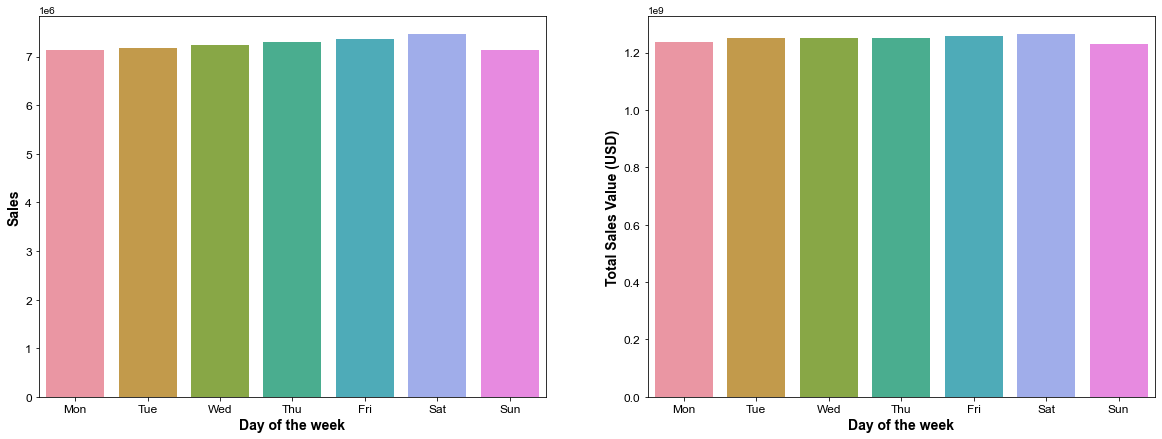

In [26]:
# Plotting day of the week
fig, ax = plt.subplots(1, 2, figsize=(20,7))

sns.barplot(data=sum_day, x='day', y='sales', ax=ax[0])
ax[0].tick_params(axis='both', labelsize=12)
ax[0].set_ylabel('Sales', fontsize=14, weight='bold')
ax[0].set_xlabel('Day of the week', fontsize=14, weight='bold')

sns.barplot(data=sum_day_total, x='day', y='purchase_total', ax=ax[1])
ax[1].tick_params(axis='both', labelsize=12)
ax[1].set_ylabel('Total Sales Value (USD)', fontsize=14, weight='bold')
ax[1].set_xlabel('Day of the week', fontsize=14, weight='bold')

plt.show()

When looking at the charts, both in the number of sales and total sales value we have Sunday as the least profitable day of the week, with Friday and Saturday being the most important day for sales, while the latter was the most profitable one.

Another way we can look at it is by type of day. Usually, it can be expected that weekends should have the higher number of sales.

In [27]:
# Fixing weekend labels
import calendar
sum_weekend['weekend'] = ["Weekend" if x > 0 else "Weekday" for x in sum_weekend.index ]
sum_weekend_total['weekend'] = ["Weekend" if x > 0 else "Weekday" for x in sum_weekend_total.index]

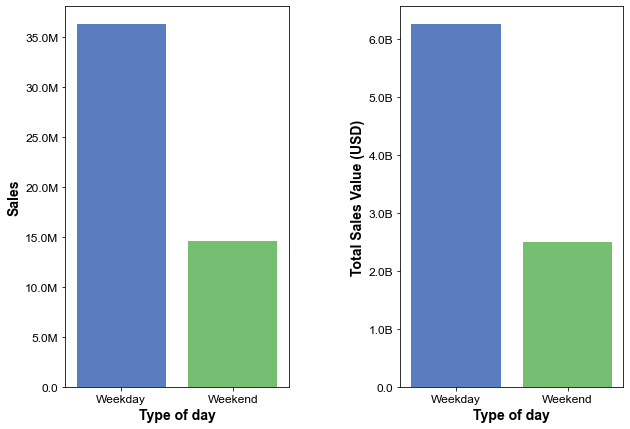

In [28]:
# Plotting weekend
fig, ax = plt.subplots(1, 2, figsize=(10,7))

sns.barplot(data=sum_weekend, x='weekend', y='sales', ax=ax[0])
ax[0].tick_params(axis='both', labelsize=12)
ax[0].set_ylabel('Sales', fontsize=14, weight='bold')
ax[0].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[0].set_xlabel('Type of day', fontsize=14, weight='bold')

sns.barplot(data=sum_weekend_total, x='weekend', y='purchase_total', ax=ax[1])
ax[1].tick_params(axis='both', labelsize=12)
ax[1].set_ylabel('Total Sales Value (USD)', fontsize=14, weight='bold')
ax[1].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[1].set_xlabel('Type of day', fontsize=14, weight='bold')

plt.subplots_adjust(wspace=0.5)
plt.show()

When we look at it this way, we can see that weekdays represent most of the revenue/sales in the studied period. However, this is confounded by the fact that we have 5 week days in contrast with only 2 weekend days. We can look at it proportionally by dividing the total values by the number of days in each category. This time since the difference is less pronounced we will make a plot with a broken axis to better illustrate the results.

In [29]:
# Fixing weekend (proportional) labels
sum_weekend_prop['weekend'] = ["Weekend" if x > 0 else "Weekday" for x in sum_weekend_prop.index ]
sum_weekend_prop_total['weekend'] = ["Weekend" if x > 0 else "Weekday" for x in sum_weekend_prop_total.index]

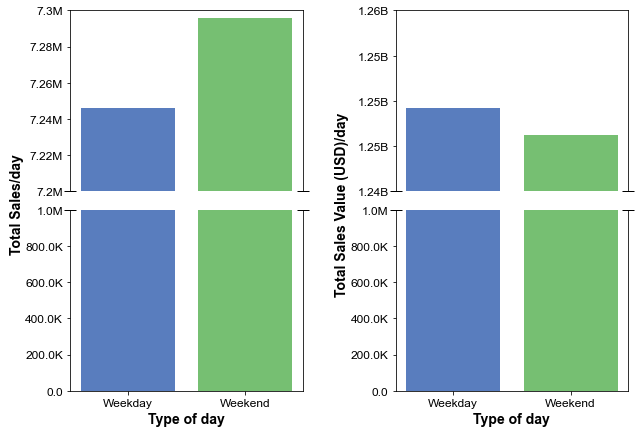

In [30]:
# Plotting weekend (proportional)
fig, ax = plt.subplots(2, 2, figsize=(10,7))
ax[1,0].sharex(ax[0,0])
ax[1,1].sharex(ax[0,1])

## First plot

# Defining plot
sns.barplot(data=sum_weekend_prop, x='weekend', y='sales', ax=ax[0,0])
sns.barplot(data=sum_weekend_prop, x='weekend', y='sales', ax=ax[1,0])

# Selecting what values to display
ax[0,0].set_ylim(7.2e6, 7.3e6)  # outliers only
ax[1,0].set_ylim(0, 1e6)  # most of the data

# Formatting spines/axes from graphs
ax[0,0].yaxis.set_major_formatter(mytools.reformat_large_tick_values) # Reformat numbers
ax[0,0].spines.bottom.set_visible(False) # Remove axis spine
ax[0,0].tick_params(bottom=False, axis="both", labelsize=12) # Don't put tick labels at bottom of first graph
ax[0,0].get_xaxis().set_visible(False) # Hide tick values
ax[0,0].set_xlabel('Type of day', fontsize=14, weight='bold') # Hide x title
ax[0,0].set_ylabel('Total Sales/day', fontsize=14, weight='bold')
ax[0,0].tick_params(labeltop=False)  # Don't put tick labels at the top of second graph
ax[1,0].xaxis.tick_bottom() # Set ticks to bottom of second graph

ax[1,0].yaxis.set_major_formatter(mytools.reformat_large_tick_values) # Reformat numbers
ax[1,0].spines.top.set_visible(False) # Remove axis spine
ax[1,0].tick_params(axis='both', labelsize=12)
ax[1,0].set_ylabel(' ', fontsize=14, weight='bold')
ax[1,0].set_xlabel('Type of day', fontsize=14, weight='bold')

# Create cut line
d = 0 # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0,0].plot([0, 1], [0, 0], transform=ax[0,0].transAxes, **kwargs)
ax[1,0].plot([0, 1], [1, 1], transform=ax[1,0].transAxes, **kwargs)


## Creating second plot

# Defining plot
sns.barplot(data=sum_weekend_prop_total, x='weekend', y='purchase_total', ax=ax[0,1])
sns.barplot(data=sum_weekend_prop_total, x='weekend', y='purchase_total', ax=ax[1,1])

# Selecting what values to display
ax[0,1].set_ylim(1.24e9, 1.26e9)  # outliers only
ax[1,1].set_ylim(0, 1e6)  # most of the data

# Formatting spines/axes from graphs
ax[0,1].yaxis.set_major_formatter(mytools.reformat_large_tick_values) # Reformat numbers
ax[0,1].spines.bottom.set_visible(False) # Remove axis spine
ax[0,1].tick_params(bottom=False) # Don't put tick labels at bottom of first graph
ax[0,1].get_xaxis().set_visible(False) # Hide tick values
ax[0,1].set_xlabel('Type of day', fontsize=14, weight='bold') # Hide x title
ax[0,1].tick_params(labeltop=False, axis="both", labelsize=12)  # Don't put tick labels at the top of second graph
ax[0,1].set_ylabel('Total Sales Value (USD)/day', fontsize=14, weight='bold')

ax[1,1].xaxis.tick_bottom() # Set ticks to bottom of second graph
ax[1,1].yaxis.set_major_formatter(mytools.reformat_large_tick_values) # Reformat numbers
ax[1,1].spines.top.set_visible(False) # Remove axis spine
ax[1,1].tick_params(axis='both', labelsize=12)
ax[1,1].set_ylabel(' ', fontsize=14, weight='bold')
ax[1,1].set_xlabel('Type of day', fontsize=14, weight='bold')

# Create cutline
d = 0  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)

ax[0,1].plot([0, 1], [0, 0], transform=ax[0,1].transAxes, **kwargs)
ax[1,1].plot([0, 1], [1, 1], transform=ax[1,1].transAxes, **kwargs)

ax[0,1].yaxis.set_label_coords(-0.2, -0.07)
ax[0,0].yaxis.set_label_coords(-0.2, -0.07)

plt.subplots_adjust(hspace=0.1, wspace=0.4)
plt.show()

When we look at total sales by type of day proportionally, we see that weekend days sell more in terms of wine bottle numbers. This idea could be biased by the superior number of sales on Saturday, which skews the proportion towards the weekends. However, in terms of total revenue weekdays become superior, although the difference is small. This might indicate that more expensive wines are consumed during regular days of the week, for example. 

Let's look at it monthly and yearly now.

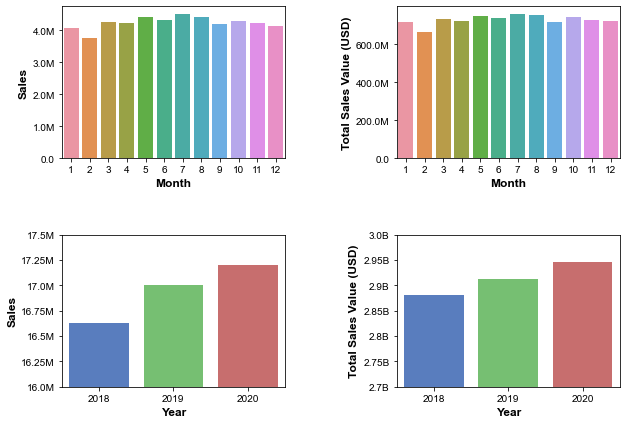

In [31]:
# Plotting month and year
fig, ax = plt.subplots(2, 2, figsize=(10,7))

sns.barplot(data=sum_month, x=sum_month.index, y='sales', ax=ax[0,0])
ax[0,0].tick_params(axis='both', labelsize=10)
ax[0,0].set_ylabel('Sales', fontsize=12, weight='bold')
ax[0,0].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[0,0].set_xlabel('Month', fontsize=12, weight='bold')

sns.barplot(data=sum_month_total, x=sum_month_total.index, y='purchase_total', ax=ax[0,1])
ax[0,1].tick_params(axis='both', labelsize=10)
ax[0,1].set_ylabel('Total Sales Value (USD)', fontsize=12, weight='bold')
ax[0,1].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[0,1].set_xlabel('Month', fontsize=12, weight='bold')

sns.barplot(data=sum_year, x=sum_year.index, y='sales', ax=ax[1,0])
ax[1,0].tick_params(axis='both', labelsize=10)
ax[1,0].set_ylabel('Sales', fontsize=12, weight='bold')
ax[1,0].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[1,0].set_xlabel('Year', fontsize=12, weight='bold')

sns.barplot(data=sum_year_total, x=sum_year_total.index, y='purchase_total', ax=ax[1,1])
ax[1,1].tick_params(axis='both', labelsize=10)
ax[1,1].set_ylabel('Total Sales Value (USD)', fontsize=12, weight='bold')
ax[1,1].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[1,1].set_xlabel('Year', fontsize=12, weight='bold')

ax[1,0].set_ylim(16e6, 17.5e6)
ax[1,1].set_ylim(2.7e9, 3e9)

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

For monthly data, we can see a trend of increase towards the middle of the year. For yearly data, as the years progressed we had an increase in our sales.

Now let's look at our other characteristics.

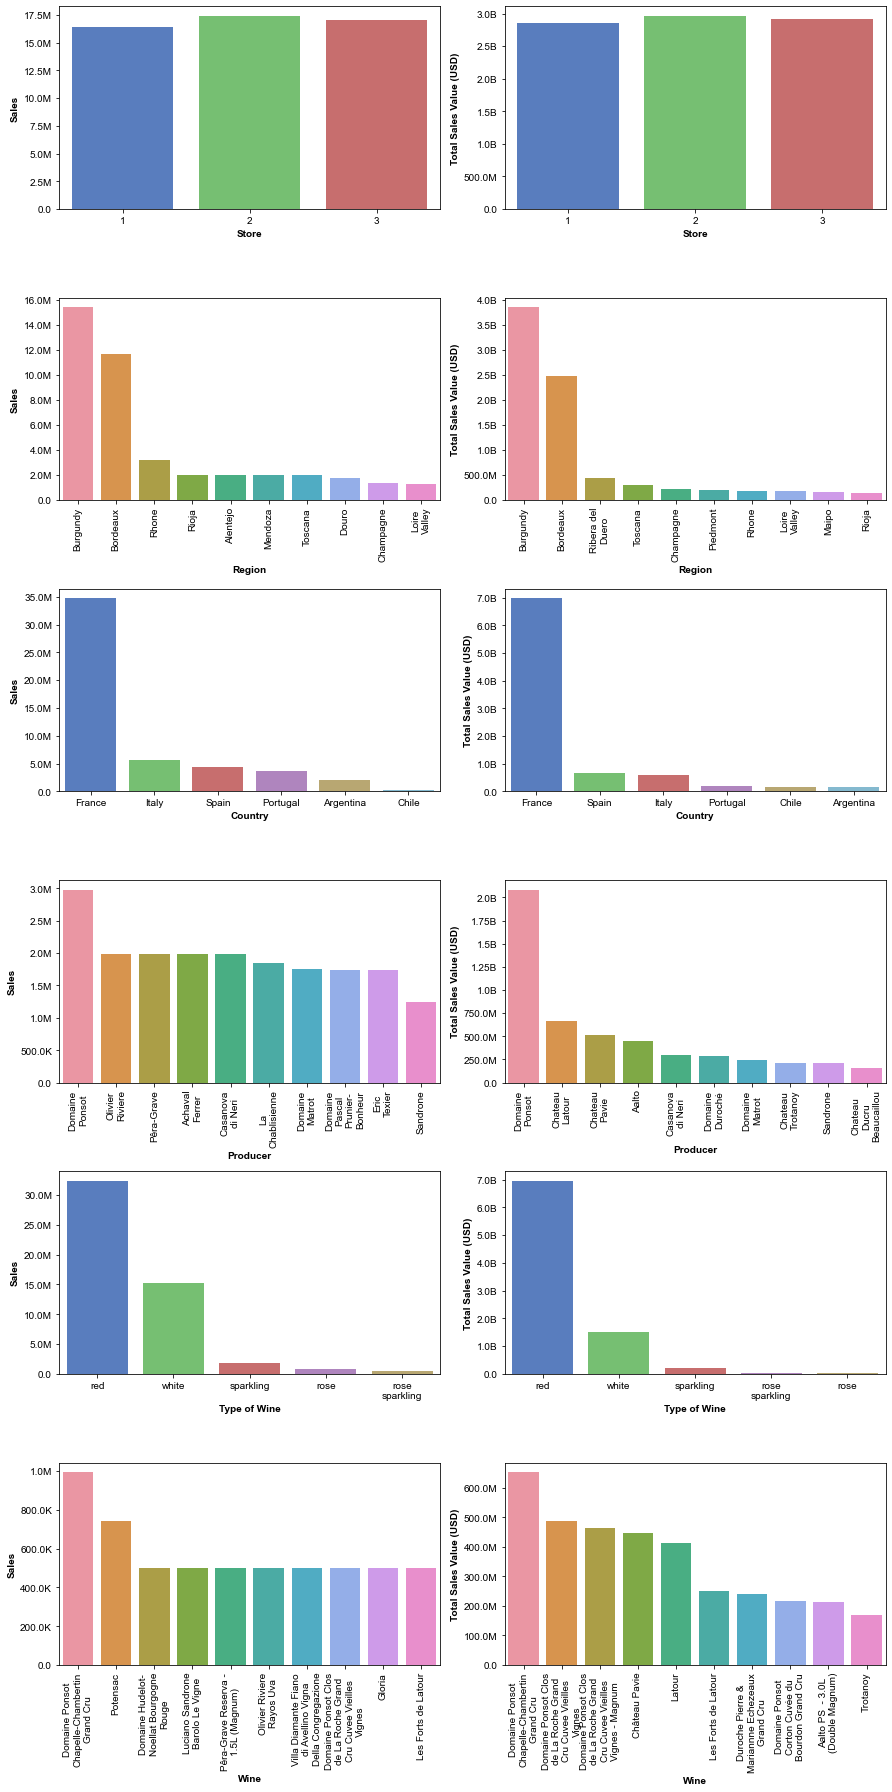

In [32]:
# Plotting weekend
fig, ax = plt.subplots(6, 2, figsize=(12.5,25))

# By Store
sns.barplot(data=sum_store, x=sum_store.index, y='sales', ax=ax[0,0])
ax[0,0].tick_params(axis='both', labelsize=10)
ax[0,0].set_ylabel('Sales', fontsize=10, weight='bold')
ax[0,0].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[0,0].set_xlabel('Store', fontsize=10, weight='bold')

sns.barplot(data=sum_store_total, x=sum_store_total.index, y='purchase_total', ax=ax[0,1])
ax[0,1].tick_params(axis='both', labelsize=10)
ax[0,1].set_ylabel('Total Sales Value (USD)', fontsize=10, weight='bold')
ax[0,1].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[0,1].set_xlabel('Store', fontsize=10, weight='bold')

# By Region
sns.barplot(data=sum_region, x=sum_region.index, y='sales', ax=ax[1,0],
            order=sum_region.sort_values('sales', ascending=False).index[0:10])
ax[1,0].tick_params(axis='both', labelsize=10)
ax[1,0].set_ylabel('Sales', fontsize=10, weight='bold')
ax[1,0].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[1,0].set_xlabel('Region', fontsize=10, weight='bold')
mytools.wrap_labels(ax[1,0], 10)
ax[1,0].tick_params(axis='x', rotation=90)

sns.barplot(data=sum_region_total, x=sum_region_total.index, y='purchase_total', ax=ax[1,1],
            order=sum_region_total.sort_values('purchase_total', ascending=False).index[0:10])
ax[1,1].tick_params(axis='both', labelsize=10)
ax[1,1].set_ylabel('Total Sales Value (USD)', fontsize=10, weight='bold')
ax[1,1].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[1,1].set_xlabel('Region', fontsize=10, weight='bold')
mytools.wrap_labels(ax[1,1], 10)
ax[1,1].tick_params(axis='x', rotation=90)

# By Country
sns.barplot(data=sum_country, x=sum_country.index, y='sales', ax=ax[2,0],
            order=sum_country.sort_values('sales', ascending=False).index[0:10])
ax[2,0].tick_params(axis='both', labelsize=10)
ax[2,0].set_ylabel('Sales', fontsize=10, weight='bold')
ax[2,0].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[2,0].set_xlabel('Country', fontsize=10, weight='bold')
mytools.wrap_labels(ax[2,0], 10)
#ax[2,0].tick_params(axis='x', rotation=90)

sns.barplot(data=sum_country_total, x=sum_country_total.index, y='purchase_total', ax=ax[2,1],
            order=sum_country_total.sort_values('purchase_total', ascending=False).index[0:10])
ax[2,1].tick_params(axis='both', labelsize=10)
ax[2,1].set_ylabel('Total Sales Value (USD)', fontsize=10, weight='bold')
ax[2,1].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[2,1].set_xlabel('Country', fontsize=10, weight='bold')
mytools.wrap_labels(ax[2,1], 10)
#ax[2,1].tick_params(axis='x', rotation=90)

# By Producer
sns.barplot(data=sum_prod, x=sum_prod.index, y='sales', ax=ax[3,0],
            order=sum_prod.sort_values('sales', ascending=False).index[0:10])
ax[3,0].tick_params(axis='both', labelsize=10)
ax[3,0].set_ylabel('Sales', fontsize=10, weight='bold')
ax[3,0].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[3,0].set_xlabel('Producer', fontsize=10, weight='bold')
mytools.wrap_labels(ax[3,0], 10)
ax[3,0].tick_params(axis='x', rotation=90)

sns.barplot(data=sum_prod_total, x=sum_prod_total.index, y='purchase_total', ax=ax[3,1],
            order=sum_prod_total.sort_values('purchase_total', ascending=False).index[0:10])
ax[3,1].tick_params(axis='both', labelsize=10)
ax[3,1].set_ylabel('Total Sales Value (USD)', fontsize=10, weight='bold')
ax[3,1].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[3,1].set_xlabel('Producer', fontsize=10, weight='bold')
mytools.wrap_labels(ax[3,1], 10)
ax[3,1].tick_params(axis='x', rotation=90)

# By kind of wine
sns.barplot(data=sum_kind, x=sum_kind.index, y='sales', ax=ax[4,0],
            order=sum_kind.sort_values('sales', ascending=False).index[0:10])
ax[4,0].tick_params(axis='both', labelsize=10)
ax[4,0].set_ylabel('Sales', fontsize=10, weight='bold')
ax[4,0].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[4,0].set_xlabel('Type of Wine', fontsize=10, weight='bold')
mytools.wrap_labels(ax[4,0], 10)
#ax[4,0].tick_params(axis='x', rotation=90)

sns.barplot(data=sum_kind_total, x=sum_kind_total.index, y='purchase_total', ax=ax[4,1],
            order=sum_kind_total.sort_values('purchase_total', ascending=False).index[0:10])
ax[4,1].tick_params(axis='both', labelsize=10)
ax[4,1].set_ylabel('Total Sales Value (USD)', fontsize=10, weight='bold')
ax[4,1].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[4,1].set_xlabel('Type of Wine', fontsize=10, weight='bold')
mytools.wrap_labels(ax[4,1], 10)
#ax[4,1].tick_params(axis='x', rotation=90)

# By Wine
sns.barplot(data=sum_wine, x=sum_wine.index, y='sales', ax=ax[5,0],
            order=sum_wine.sort_values('sales', ascending=False).index[0:10])
ax[5,0].tick_params(axis='both', labelsize=10)
ax[5,0].set_ylabel('Sales', fontsize=10, weight='bold')
ax[5,0].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[5,0].set_xlabel('Wine', fontsize=10, weight='bold')
mytools.wrap_labels(ax[5,0], 20)
ax[5,0].tick_params(axis='x', rotation=90)

sns.barplot(data=sum_wine_total, x=sum_wine_total.index, y='purchase_total', ax=ax[5,1],
            order=sum_wine_total.sort_values('purchase_total', ascending=False).index[0:10])
ax[5,1].tick_params(axis='both', labelsize=10)
ax[5,1].set_ylabel('Total Sales Value (USD)', fontsize=10, weight='bold')
ax[5,1].yaxis.set_major_formatter(mytools.reformat_large_tick_values)
ax[5,1].set_xlabel('Wine', fontsize=10, weight='bold')
mytools.wrap_labels(ax[5,1], 20)
ax[5,1].tick_params(axis='x', rotation=90)

fig.tight_layout()
plt.show()

Sales between stores were very similar, with **store number 2** presenting a slight increase in sales. **Burgundy** and **Bordeaux** wines were the most sought after, matching the most common country of origin, **France**. As for the preferred types of wine, we have **Red** followed by **White** which is expected.

For the most sold wines, in total number of sales we have ***Domaine Ponsot Chapelle-Chambertin Grand Cru*** followed by ***Potensac***. In terms of total revenue, the top 1 remained but is followed by ***Domaine Ponsot Clos de La Roche Grand Cru Cuvee Vieilles Vignes***. Furthermore, Ponsot had two of the wines that generated the most revenue, indicating the importance of their availability for customers. Let's check the price of these wines:

In [33]:
wines_list = ['Domaine Ponsot Chapelle-Chambertin Grand Cru', 'Potensac', 'Domaine Ponsot Clos de La Roche Grand Cru Cuvee Vieilles Vignes']

df_prod.loc[df_prod.name.isin(wines_list), ['name', 'price_usd']]

,name,price_usd
87,Domaine Ponsot Chapelle-Chambertin Grand Cru,656.06
88,Domaine Ponsot Chapelle-Chambertin Grand Cru,656.06
89,Domaine Ponsot Chapelle-Chambertin Grand Cru,656.06
90,Domaine Ponsot Chapelle-Chambertin Grand Cru,656.06
91,Domaine Ponsot Clos de La Roche Grand Cru Cuve...,1037.02
92,Domaine Ponsot Clos de La Roche Grand Cru Cuve...,915.57
108,Potensac,112.32
109,Potensac,51.78
110,Potensac,63.94


In [34]:
df_prod.describe().price_usd

count     219.000000
mean      167.407808
std       243.873780
min         9.130000
25%        45.725000
50%        88.130000
75%       164.220000
max      1901.730000
Name: price_usd, dtype: float64

The most sold wine was a fairly expensive one, but not the most pricey in our catalog. The second most sold one had a price around the median of our list of wines. Although it was the second most sold one, it didn't reach enough revenue as the second one in terms of total revenue (which was the 8th most sold wine) and did not reach the top 10 in the generation of revenue. 

In [35]:
print("Potensac wine ranked {:} in Total Sales Value (USD).".format(sum_wine_total.index.get_loc('Potensac')))

Potensac wine ranked 164 in Total Sales Value (USD).


Now that we have a general idea about our dataset, let's get into the matter at hand: Time Series Prediction.

# Time Series Forecasting

Before diving into demand forecasting, it is important to notice that even though ***Prophet*** is a very robust framework, it requires that an assumption is met for us to have reliable results.

## Assumption

The first thing is **seasonality**. Our data need to have patterns that repeat again and again over a given period. The second assumption is that the time series is **stationary**, *i.e.* its statistical properties (such as mean and variance) do not change over time. These effects are also assumed to work as an **additive model** <sup><a href="https://mlpills.dev/time-series/time-series-forecasting-with-facebook-prophet-i/">6</a></sup>.
These aspects can be verified using plots and statistical tests (for checking if the time series is stationary). Let's prepare our data and check for these characteristics.

## Preparing data for Prophet

Prophet requires a specific format. A `ds` column storing the dates information and a `y` column with the value we want to forecast (in this case, the sales information). We'll gather the sales numbers by dates and rename the columns afterwards.

In [36]:
# Prepare data for prophet
df_prophet = df.groupby('dateofsale', as_index=False)['sales'].sum()
df_prophet.columns = ['ds', 'y']
df_prophet.head

<bound method NDFrame.head of              ds      y
0    2018-01-01  43432
1    2018-01-02  43181
2    2018-01-03  43298
3    2018-01-04  42216
4    2018-01-05  42001
...         ...    ...
1091 2020-12-27  45931
1092 2020-12-28  42754
1093 2020-12-29  43804
1094 2020-12-30  44546
1095 2020-12-31  44592

[1096 rows x 2 columns]>

## Checking assumptions

Now, let's check our assumptions.

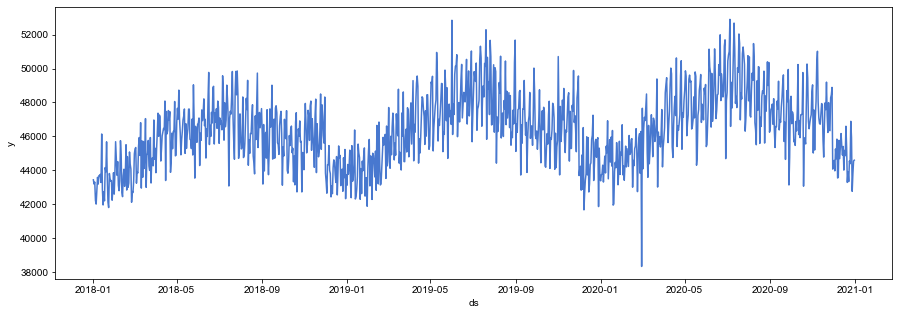

In [37]:
# Plotting our time series
fig, ax = plt.subplots(figsize=(15,5))

sns.lineplot(x=df_prophet.ds, y=df_prophet.y)

plt.show()

From this simple plot, we can verify that our dataset has seasonality that is not due to the main variable observed (date of sales), it has a trend (increase over time) and does not appear to be stationary. Thus, we will perform a statistical test to determine if our data is stationary or not.

### Augmented Dickey—Fuller test

The *Augmented Dickey Fuller* test, or **ADF**, is a type of statistical test to define if a time series is stationary or not given the presence of Unit Roots (features in the distribution of the time-series that makes it non-stationary when 1 is a root of the process characteristic equation)<sup><a href="https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/">7</a></sup>. As it is a statistical test, it is based on the null hypothesis (H<sub>0</sub>) that our time-series is not stationary. Therefore, if we have a p-value lower than the threshold considered (here we will consider 0.05 as the p-value threshold) we can reject the H<sub>0</sub> and assume our time-series as stationary.

In [38]:
# Running ADF test
adf_res = adfuller(df_prophet.y)

# Printing results
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(adf_res[0]))
print('Test p-value: {:.5f}'.format(adf_res[1]))


Augmented Dickey–Fuller
Statistical Test: -2.3601
Test p-value: 0.15333


With a p-value of over 0.15, we cannot successfully reject our null hypothesis. Therefore, we must perform some adjustments in order to transform our series into a stationary one. A good procedure is transforming the series into a logarithmic scale, which will deflate the values, and another one is to subtract the moving average from the data, to remove the trend.

Let's check how our moving average would look like.

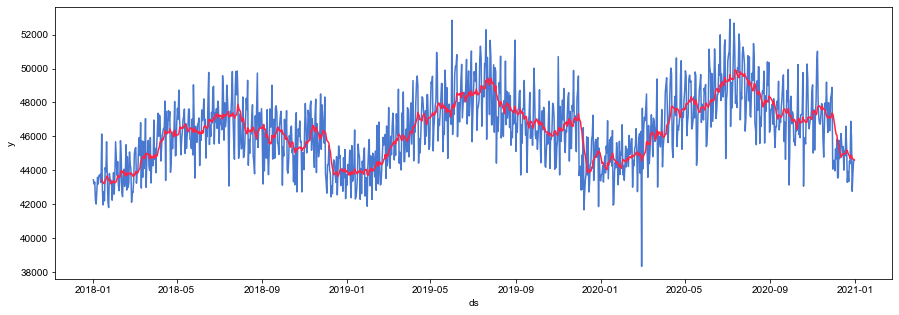

In [39]:
# Checking the original plot with moving average
ma = df_prophet.rolling(13).mean()
ma.index = df_prophet.ds

fig, ax = plt.subplots(figsize=(15,5))

sns.lineplot(x=df_prophet.ds, y=df_prophet.y)
sns.lineplot(x=ma.index, y=ma.y, color = "#FF2345", legend=False)

plt.show()

Now, let's transform our values to the log scale.

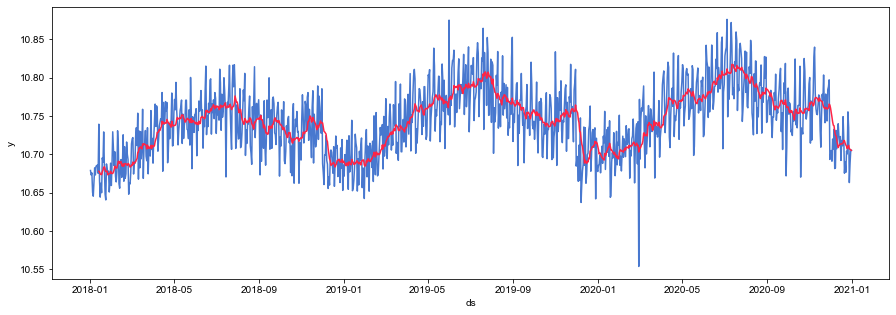

In [40]:
# Log scale
df_prophet_log = df_prophet.copy()
df_prophet_log.y = np.log(df_prophet_log.y)

# Moving average
ma_log = df_prophet_log.rolling(13).mean()
ma_log.index = df_prophet_log.ds

# Plotting
fig, ax = plt.subplots(figsize=(15,5))

sns.lineplot(x=df_prophet_log.ds, y=df_prophet_log.y)
sns.lineplot(x=ma.index, y=ma_log.y, color="#FF2345")


plt.show()

Now that our data has been transformed into log scale we can subtract the moving average from the data.

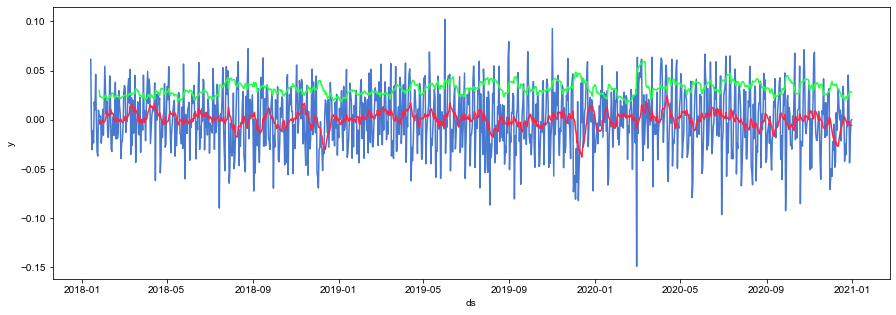

In [41]:
# Creating new dataframe and subtracting
df_prophet_sub = df_prophet_log.copy()
df_prophet_sub.index = df_prophet_sub.ds
df_prophet_sub.y = (df_prophet_sub.y - ma_log.y).dropna()
df_prophet_sub = df_prophet_sub.dropna()

ma_sub = df_prophet_sub.rolling(13).mean()
ma_sub.index = df_prophet_sub.ds
std_sub = df_prophet_sub.rolling(13).std()
std_sub.index = df_prophet_sub.ds

# Plotting
fig, ax = plt.subplots(figsize=(15,5))

sns.lineplot(x=df_prophet_sub.ds, y=df_prophet_sub.y)
sns.lineplot(x=ma_sub.index, y=ma_sub.y, color="#FF2345")
sns.lineplot(x=std_sub.index, y=std_sub.y, color="#23FF45")

plt.show()

See how the trend in the data was reduced? Now, we can check what we have when we perform another Augmented Dickey—Fuller test.

In [42]:
# Running ADF test
adf_sub = adfuller(df_prophet_sub.y)

# Printing results
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(adf_sub[0]))
print('Test p-value: {:.10f}'.format(adf_sub[1]))


Augmented Dickey–Fuller
Statistical Test: -6.6748
Test p-value: 0.0000000045


And this is how we get a stationary time series to proceed with our forecasting analysis.

## Demand Forecasting

Now, we have everything we need to do time series forecasting with Facebook's Prophet. For comparison purposes, we will do the same for the three datasets and see how it changes our predictions.

First, let's look at our stationary series.

In [43]:
# Resetting index
df_prophet_sub.reset_index(inplace=True, drop=True)

# Checking df again
df_prophet_sub.head()

,ds,y
0,2018-01-13,0.061408
1,2018-01-14,-0.011249
2,2018-01-15,-0.030485
3,2018-01-16,-0.011219
4,2018-01-17,-0.023637


Now, we define the size of the prediction we want to make, and make a `train` dataset without the time frame we want to forecast. Afterwards, we can initiate our model, fit the data and make our predictions.

In [44]:
# Defining forecasting size
forecast_size = 30

# Defining training dataframe
train_df = df_prophet_sub[:-forecast_size]

# Initiating model
m = Prophet()

# Training with our data
m.fit(train_df)

18:32:41 - cmdstanpy - INFO - Chain [1] start processing
18:32:41 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
# Making our predictions
predict = m.make_future_dataframe(periods=forecast_size)
forecast = m.predict(predict)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-13,0.000513,-0.003678,0.062785,0.000513,0.000513,0.028469,0.028469,0.028469,0.029108,0.029108,0.029108,-0.000639,-0.000639,-0.000639,0.0,0.0,0.0,0.028981
1,2018-01-14,0.000507,-0.053243,0.014411,0.000507,0.000507,-0.017698,-0.017698,-0.017698,-0.017088,-0.017088,-0.017088,-0.000610,-0.000610,-0.000610,0.0,0.0,0.0,-0.017191
2,2018-01-15,0.000502,-0.055219,0.012980,0.000502,0.000502,-0.020984,-0.020984,-0.020984,-0.020431,-0.020431,-0.020431,-0.000553,-0.000553,-0.000553,0.0,0.0,0.0,-0.020482
3,2018-01-16,0.000496,-0.046853,0.020626,0.000496,0.000496,-0.014122,-0.014122,-0.014122,-0.013651,-0.013651,-0.013651,-0.000470,-0.000470,-0.000470,0.0,0.0,0.0,-0.013625
4,2018-01-17,0.000491,-0.039731,0.026498,0.000491,0.000491,-0.005690,-0.005690,-0.005690,-0.005323,-0.005323,-0.005323,-0.000367,-0.000367,-0.000367,0.0,0.0,0.0,-0.005199


Now, to analyse the result, let's define a code to make a new dataframe in order to plot the data we obtained from prophet and another to calculate our error metrics.

In [46]:
# Creating function to obtain results
def compareForecast(history, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(history.set_index('ds'))

def forecastMetrics(df, pred_size):

    df_metrics = df.copy()
    df_metrics['e'] = df_metrics['y'] - df_metrics['yhat']
    df_metrics['p'] = 100 * df_metrics['e'] / df_metrics['y']

    pred_part = df_metrics[-pred_size:]

    error_mean = lambda error_name: np.mean(np.abs(pred_part[error_name]))
    
    final_df = pd.DataFrame({'MAPE': error_mean('p'), 'MAE': error_mean('e')}, index=[0])
    
    return(final_df)

In [47]:
# Creating our results data.frame
compare_df = compareForecast(df_prophet_sub, forecast)

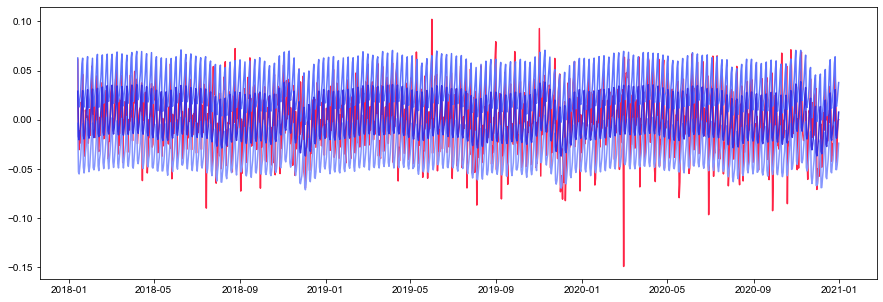

In [48]:
# Seeing our results
fig, ax = plt.subplots(figsize=(15,5))

cols = ['y', 'yhat_lower', 'yhat_upper', 'yhat']
pal = ['#FF2345', '#8696FE', '#5f74fe', '#3831e2']


for i in range(0,4,1):
    plt.plot(compare_df[cols[i]], color=pal[i], linestyle='-')

    
plt.show()

In [49]:
# Now checking our metrics
forecastMetrics(compare_df, forecast_size)

,MAPE,MAE
0,930.965482,0.020162


So, when we check our metrics, we have a very low MAE but an extremely high MAPE. The high MAPE would mean that our model was wrong by 930% when our error margin was actually quite low. This could be an artifact of the way we treated our data.

Prophet is said to perform well even without stationary data. So, let's check our log-transformed data and build a model for that instead.

In [50]:
# Resetting index
df_prophet_log.reset_index(inplace=True, drop=True)

# Checking df again
df_prophet_log.head()

,ds,y
0,2018-01-01,10.678952
1,2018-01-02,10.673156
2,2018-01-03,10.675862
3,2018-01-04,10.650555
4,2018-01-05,10.645449


In [51]:
# Defining forecasting size
forecast_size = 30

# Defining training dataframe
train_df_log = df_prophet_log[:-forecast_size]

# Initiating model
m_log = Prophet()

# Training with our data
m_log.fit(train_df_log)

18:32:41 - cmdstanpy - INFO - Chain [1] start processing
18:32:42 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
# Making our predictions
predict_log = m_log.make_future_dataframe(periods=forecast_size)
forecast_log = m_log.predict(predict_log)

# Creating our results data.frame
compare_df_log = compareForecast(df_prophet_log, forecast_log)

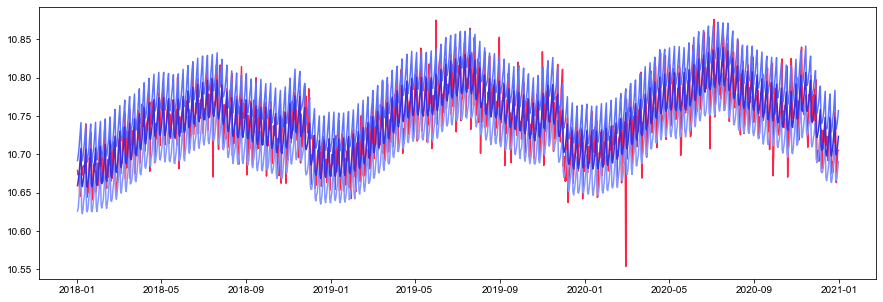

In [53]:
# Seeing our results
fig, ax = plt.subplots(figsize=(15,5))

cols = ['y', 'yhat_lower', 'yhat_upper', 'yhat']
pal = ['#FF2345', '#8696FE', '#5f74fe', '#3831e2']


for i in range(0,4,1):
    plt.plot(compare_df_log[cols[i]], color=pal[i], linestyle='-')

    
plt.show()

In [54]:
# Now checking our metrics
forecastMetrics(compare_df_log, forecast_size)

,MAPE,MAE
0,0.202182,0.02164


This time, we get a very similar MAE and a very small MAPE, of around 0.2% error! Using just the log-scaled data, we get very good results and are successfully able to predict the future of our wine sales demand.

However, these values are still in log scale, so we have to convert them back in order to fully interpret them.

### Converting the values back

In [55]:
# Creating new dataframe
df_real = forecast_log[['ds', 'yhat']].copy()
df_real['SpentValueLog'] = df_prophet_log['y']
df_real['SpentValue'] = np.exp(df_real['SpentValueLog'].values)
df_real['SpentPredicted'] = np.exp(df_real['yhat'].values)
df_real.head()


,ds,yhat,SpentValueLog,SpentValue,SpentPredicted
0,2018-01-01,10.659247,10.678952,43432.0,42584.550180
1,2018-01-02,10.665289,10.673156,43181.0,42842.632092
2,2018-01-03,10.672556,10.675862,43298.0,43155.106131
3,2018-01-04,10.682771,10.650555,42216.0,43598.184986
4,2018-01-05,10.696075,10.645449,42001.0,44182.121135


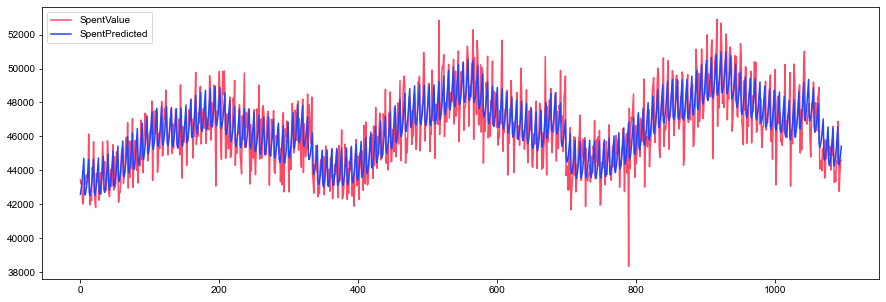

In [56]:
# Plotting our predictions
fig, ax = plt.subplots(figsize=(15,5))

cols = ['SpentValue', 'SpentPredicted']
pal = ['#FF4A66', '#2345FF']

for i in range(0,2,1):
    ax.plot(df_real[cols[i]], color=pal[i], linestyle='-', label=cols[i])

ax.legend(loc='upper left')

plt.show()

Using only the log-transformed model, we get very good prediction values that are closer to the upper peaks than the lower peaks in our time-series, but are very similar to our real data and shows minimum error when considering a time-frame of 30 days.

We can still get some information from our model. We can look at Prophet's model components:

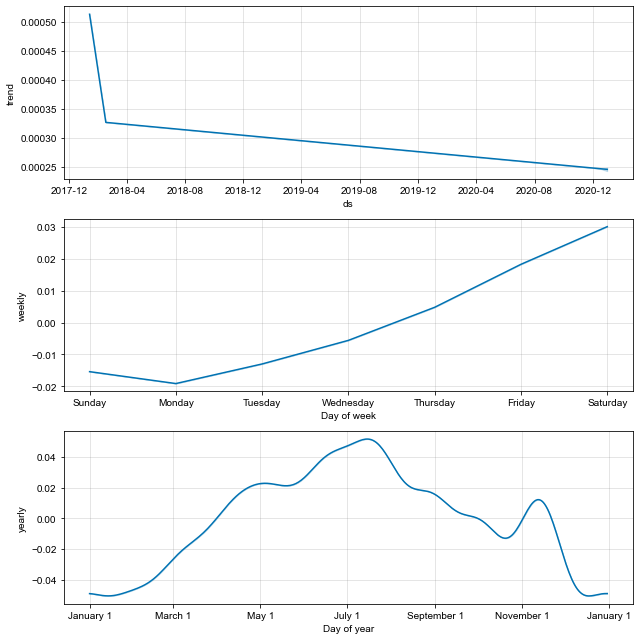

In [57]:
m_log.plot_components(forecast);

From this data, we can see that we have an overall increase in the sales trend (first plot). It also appears that our sales are higher towards the end of the week (Friday and Saturday). Meanwhile, the middle of the year (around July) is when we sell most of our wines! These are valuable insights that can guide the company to establish business strategies.

## Conclusions

Our model was very good at predicting wine sales, even with non-stationary data. Even though stationary data are said to work better for forecasting algorithms, we saw that we had virtually no difference in mean absolute error (MAE), but our percentage error was gravely inflated (over 930%!) when using our model on data smoothed using the moving average. 

This only appeared to affect the mean absolute percentage error (MAPE) metric but warrants caution when one needs to transform the data in order to fit the models. It does not necessarily mean that you will have a bad model, so more than one error metric should be used when assessing the predictions. Overall, Prophet shows itself as a good tool to analyse time series data.

## References

1: https://www.mayoclinic.org/diseases-conditions/heart-disease/in-depth/red-wine/art-20048281

2: https://www.forbes.com/sites/joemicallef/2021/06/22/how-post-pandemic-wine-consumption-trends-are-shaping--demand/?sh=6fa845857fe9

3: https://en.wikipedia.org/wiki/Time_series

4: https://facebook.github.io/prophet/

5: https://startup.info/why-demand-forecasting-is-important/

6: https://mlpills.dev/time-series/time-series-forecasting-with-facebook-prophet-i/

7: https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/